# Decision Making Under Uncertainty - Assignment 1

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

In [1]:
import random
import math
import itertools
import re

import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb
from scipy import stats

In [2]:
# Set parameters
num_instances = 10
num_items = 10
g = 2 # group number

# Generation of Problem Instances
## Part 1
In the first part, we want to generate 10 random instances of the Stochastic Knapsack Problem (SKP). For this, we need to generate values for the low weights using the Poisson distribution. From Lab 2, we know that the `numpy.random` library is the fastest in doing this. For the high weights, we will use the same library, using the `triangular()` function from `numpy.random`.


In [3]:
def generate_instance(num_items, g, seed):
    """Generate a dictionary of `num_items` possible item sizes

    Parameters
    ----------
    num_items : int
        Number of items to generate weights for
    g : int
        Group number
    seed : int
        Random seed

    Returns
    -------
    item_sizes : dict
        Dictionary containing the possible item sizes
    """

    # Assert inputs are of correct form
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"
    assert isinstance(seed, int), "seed is not an int"

    # Generate possible item sizes.
    np.random.seed(seed)
    lam = [math.ceil((i + 1)/2) for i in range(num_items)]
    dl = np.minimum(np.random.poisson(lam), 10)
    dh = [np.random.triangular(90 + g - (i+1), 100 + g - (i+1), 110 + g - (i+1))
          for i in range(num_items)]

    item_sizes = {"dl": dl, "dh": dh}

    return item_sizes


def skp(num_instances, num_items, g):
    """Generates `num_instances` instances of a Stochastic Knapsack Problem (SKP).

    Parameters
    ----------
    num_instances : int
        Number of instances of the SKP to generate
    num_items : int
        Number of items to consider per instance
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Assert inputs are of correct form
    assert isinstance(num_instances, int), "num_instances is not an int"
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"

    # Generate instance variables
    p = math.floor(60 + 0.1 * g)  # Unit excess weight penalty
    K = 400 + 4 * g  # Knapsack capacity

    pi = np.asarray([0.5 + 0.05 * (i + 1) - 0.001 for i in range(num_items)])  # Item size probabilities
    r = np.asarray([51 - (i + 1) for i in range(num_items)])  # Revenues

    item_sizes = {j: generate_instance(num_items, g, seed=j) for j in range(num_instances)}  # dl, dh

    instance = (p, K, pi, r, item_sizes)

    return instance

In [4]:
p, K, pi, r, item_sizes = skp(num_instances, num_items, g)

# Heuristic Algorithm
## Part 2

In [5]:
def greedy_algorithm(problem_instance, pi, r, item_sizes, K):
    """Generates a selection vector for an SKP based on a greedy approach.

    Parameters
    ----------
    problem_instance : int
        Integer indicating which instance to take
    pi : list
        List of probabilities whether an item will attain a high weight
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Compute expectation of w_i for each item
    Ew = item_sizes[problem_instance]["dh"] * np.array(pi) + item_sizes[problem_instance]["dl"] * (np.array(1) - pi)
        
    sorted_expected_revenue = np.argsort(r)[::-1]

    # Initialise zero-value x and W
    x = np.zeros(10, dtype=np.int16)
    W = 0

    while len(sorted_expected_revenue) != 0:

        consider_item = sorted_expected_revenue[0]

        if W + Ew[consider_item] <= K:
            x[consider_item] = 1
            W = W + Ew[consider_item]

        sorted_expected_revenue = np.delete(sorted_expected_revenue, 0)

    return x

# Monte Carlo Simulation
## Part 3

In [6]:
problem_instance = 0
x = greedy_algorithm(problem_instance, pi, r, item_sizes, K)
print("x:", x)

x: [1 1 1 1 1 1 0 0 0 0]


In [7]:
def calculate_profits(item_sizes, x, r, pi, num_items, num_runs, problem_instance):

    profits = []

    for run in range(num_runs):
        u = np.random.uniform(size=num_items)
        w = [item_sizes[problem_instance]["dl"][i] if u[i] < pi[i] else item_sizes[problem_instance]["dh"][i]
            for i in range(num_items)]
        w = np.asarray(w)

        total_weight = np.dot(x, w)
        excess = max(total_weight-K, 0)

        profit = np.dot(x, r*w) - excess*p
        profits.append(profit)

    profits = sorted(profits)

    return profits

We want to calculate the optimal number of runs for running our Monte Carlo simulation. For this, we need to first get an estimate for the standard deviation of the distribution of the profits...

In [8]:
# Calculate number of runs; first a test run to get an estimate for sigma
profits = calculate_profits(item_sizes, x, r, pi, num_items, num_runs=1000, problem_instance=problem_instance)
sigma = np.std(profits)
print("sigma:", sigma)

sigma: 4882.083461004353


We'd like to show the distribution of the profits. Due to the jumps between selecting a certain number of high and low weights, the distribution looks highly irregular. As such, results may not necessarily be reliable. Nonetheless, as advised by the lecturer, we still take the approach as discussed in the first few lectures.

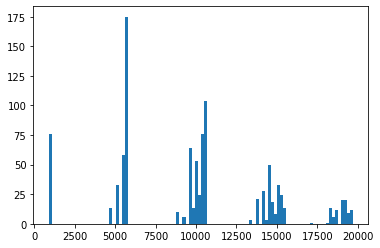

In [9]:
plt.hist(profits, bins=100)
plt.show()

We then select a value for `alpha` equal to 0.05 as the confidence level for our preferred half-width, defined by `epsilon`. This then gives us the desired number of runs:

In [10]:
alpha = 0.05
z = stats.norm.ppf(1-alpha/2)

epsilon = 0.01*np.mean(profits) # half-width
n = int(np.ceil((z*sigma/epsilon)**2))
print("n:", n)

n: 9366


Next, we find the profits for this number of runs `n` and the corresponding confidence interval.

In [11]:
# Now find profits for this number of runs...
profits = calculate_profits(item_sizes, x, r, pi, num_items, num_runs=n, problem_instance=problem_instance)

# and find the confidence interval
half_width = z*sigma/math.sqrt(n)
confidence_interval = (np.mean(profits) - half_width, np.mean(profits) + half_width)
print("Confidence interval:", confidence_interval)

Confidence interval: (9706.520244067955, 9904.26556206477)


# Stochastic Programming Models
## Part 4

In [12]:
# For testing purposes
scenario1 = [item_sizes[problem_instance]['dh'][i] if (i % 2 == 0) else item_sizes[problem_instance]['dl'][i] for i in range(num_items)]
scenario2 = [item_sizes[problem_instance]['dl'][i] if (i % 2 == 0) else item_sizes[problem_instance]['dh'][i] for i in range(num_items)]
scenario3 = [item_sizes[problem_instance]['dl'][i] if i <= 4 else item_sizes[problem_instance]['dh'][i] for i in range(num_items)]

scenario_weights = (scenario1, scenario2, scenario3)
scenario_probabilities = (1/3, 1/3, 1/3)

In [13]:
#### Create all 1024 scenarios ####
# Binary scenarios creates all possible permutations of 0 and 1
binary_scenarios = [list(i) for i in itertools.product([0, 1], repeat=num_items)]

# We will, without loss of generality, define that a 1 in binary_scenarios corresponds with a high weight
scenario_weights = [[item_sizes[problem_instance]['dh'][i] if scenario[i] == 1
                     else item_sizes[problem_instance]['dl'][i]
                     for i in range(num_items)] for scenario in binary_scenarios]
scenario_probabilities = [np.prod([pi[i] if scenario[i] == 1 else (1-pi[i])
                                   for i in range(num_items)]) for scenario in binary_scenarios]

In [14]:
def gurobi_model(r, K, p,scenario_weights, scenario_probabilities, beta=0, alpha=0.95, save_path=None):
    model = gb.Model("expected_value")
    
    num_items = len(scenario_weights[0])
    
    items = range(num_items)
    scenarios = range(len(scenario_weights))
    
    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Define variables
    x = model.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    epsilon = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0)
    eta = model.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    s = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    model.update()

    #### Write objective ####
    obj = gb.LinExpr()

    # Expected value objective
    for scenario in scenarios:
        for item in items:
            obj += (1-beta)*scenario_probabilities[scenario]*r[item]*scenario_weights[scenario][item]*x[item]
        obj -= (1-beta)*p*epsilon[scenario]

    # CVaR Objective:
    # Part 1
    obj += beta*eta[0]

    # Part 2
    for scenario in scenarios:
        # TODO: ask why we do 1/(1-a); what does it mean in practice (with relation to quantile)
        obj -= beta*(1/(1-alpha))*scenario_probabilities[scenario]*s[scenario]

    model.setObjective(obj, gb.GRB.MAXIMIZE)

    #### Write constraints ####
    # Epsilon constraint
    for scenario in scenarios:
        model.addConstr(epsilon[scenario] >= sum([scenario_weights[scenario][item]*x[item] for item in items]) - K,
                        name=f"epsilon_constraint_scenario_{scenario}")

    # S constraint
    for scenario in scenarios:
        model.addConstr(s[scenario] >= eta[0] - (sum([r[item]*scenario_weights[scenario][item]*x[item] for item in items])
                                                 - p*epsilon[scenario]),
                        name=f"s_constraint_scenario_{scenario}")
    
    # Update and, possibly, save model before optimising
    model.update()
    
    if save_path != None:
        model.write(f'{save_path}.lp')
        
    model.optimize()
    
    return model

In [ ]:
# We only want to take a sample of scenarios, say 100 (but it runs all 1024 scenarios in mere seconds too!)
sample_size = 100
random_indices = random.sample(range(len(scenario_weights)), sample_size)

selected_probabilities = [scenario_probabilities[index] for index in random_indices]
selected_weights = [scenario_weights[index] for index in random_indices]

alpha = {"EV": 0, "CVaR": 0.95}

In [15]:
model_EV = gurobi_model(r, K, p, scenario_weights = selected_weights,
                     scenario_probabilities = selected_probabilities,
                     beta=0, alpha=alpha, save_path=None)

Academic license - for non-commercial use only
Optimize a model with 200 rows, 211 columns and 2400 nonzeros
Variable types: 201 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective 945.6146514
Presolve removed 133 rows and 134 columns
Presolve time: 0.00s
Presolved: 67 rows, 77 columns, 737 nonzeros
Variable types: 66 continuous, 11 integer (11 binary)

Root relaxation: objective 1.393061e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1393.06139    0    6  945.61465 1393.06139  47.3%     -    0s
H    0     0                    1247.6876064 1393.06139  11.7%     -    0s
H    0     0                    1311.9259923 1393.06139  6.18%     -    0s
     0     0 1315.2

In [19]:
model_CVaR = gurobi_model(r, K, p, scenario_weights = selected_weights,
                     scenario_probabilities = selected_probabilities,
                     beta=1, alpha=alpha, save_path=None)

Optimize a model with 200 rows, 211 columns and 2400 nonzeros
Variable types: 201 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 33 rows and 33 columns
Presolve time: 0.01s
Presolved: 167 rows, 178 columns, 2004 nonzeros
Variable types: 168 continuous, 10 integer (10 binary)

Root relaxation: objective 1.747945e+04, 116 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17479.4539    0    5   -0.00000 17479.4539      -     -    0s
H    0     0                    17152.781874 17479.4539  1.90%     -    0s
     0     0 17436.3302    0    5 17152.7819 17436.3302  1.65%     -    0s
     0     0 17350.0704    0    6 17152.7819 17350.0704  1.15%  

In [17]:
v_EV = model_EV.getVars()

outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)

EV | x: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0] | eta: [0]


In [20]:
v_CVaR = model_CVaR.getVars()

outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)

CVar | x: [0, 1, 1, 1, 1, 0, 1, 0, 0, 1] | eta: [17665]


In [23]:
model_CVaR.ObjVal, model_EV.ObjVal

(17152.781874466946, 1311.9259923016766)

In [ ]:
# # Part 5
# # Part 6

# Sample Average Approximation
# # Part 7

# Analysis
# # Part 8

# # Part 9

# # Bonus